오토인코더 

- 머신러닝의 경우, 데이터 형태와 관계없이 정답을 알려주면 효율적으로 학습이 가능하다. ( 입력, 출력의 관계 설명)
- 데이터셋에 정답이 포함되지 않은 경우는 매우 어려운일이다. 
- 오토 인코더는 입력 x도 정답도 x이다. ( 단, 신경망은 범용근사자로서 근사치를 출력하기 때문에 x와 똑같은 출력을 내긴 힘들다. )
- 오토 인코더는 입력된 x를 복원한다는 개념이다. 
- 그래서 오차 값에도 x를 얼마나 복원했는지를 뜻하는 복원오차, 정보손실값이라는 용어를 이용한다. 
- 주요 특징은 입력과 출력의 크기는 같지만, 중간으로 갈수록 신경망의 차원이 줄어든다. (병목현상으로 인해 입력의 특징들이 압축)
- 저차원에 고인 압축된 표현을 잠재변수라 하고 z라고도 한다. 
- 잠재변수의 앞을 인코더, 뒷부분을 디코더라고 한다. 
- 오토코더의 압축은 단순히 데이터 크기를 줄이는 것이 아닌, 잠재 변수에 복잡한 데이터의 의미를 담을 수 있다.
- 정보의 압축은 정보 구성의 우선순위가 있다는 것으로, 압축이란 정보에서 덜 중요한 요소를 버리는 과정으로 정의 가능.
- 오토 인코더에서는 필연적으로 정보의 손실이 일어나, 원본의 디테일을 잃어버린다는 뜻이기도 하지만, 중요 정보만 남겨두는 일종의 데이터 가공이라 볼 수도 있다. 
- 오토 인코더는 주로 복잡한 비선형 데이터의 차원을 줄이는 용도로 쓰인다. -> 비정상 거래 검출, 데이터 시각화 복원, 의미 추출, 이미지 검색... 등


In [2]:
#오토 인코더로 이미지의 특징 추출하기 
#FashionMNIST데이터셋 이용 및 잠재변수 시각화

#라이브러리 로드
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

#하이퍼파라미터
EPOCH = 10
BATCH_SIZE = 64

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print('Using Device:', DEVICE)

#학습 데이터셋 로드 
trainset = datasets.FashionMNIST( root = './.data/',
                                train = True, 
                                download = True, 
                                transform = transforms.ToTensor())


train_loader = torch.utils.data.DataLoader( dataset = trainset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True, 
                                           num_workers = 2)



Using Device: cpu


In [9]:
#오토 인코더 모듈 정의
#인코더와 디코더로 나뉜 두 부분을 시퀀셜을 이용하여 두 모듈로 묶어준다.

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        #인코더 데이터 픽셀수인 28*28(784)차원으로 시작하여 최종적으로 3개의 차원 출력(3차원시각화위해)
        self.encoder = nn.Sequential(nn.Linear(28*28, 128),
                                    nn.ReLU(),
                                    nn.Linear(128,64),
                                    nn.ReLU(),
                                    nn.Linear(64,12),
                                    nn.ReLU(),
                                    nn.Linear(12,3))
        #디코더는 3차원 잠재변수를 받아 다시 784차원 이미지로 복원( 차이는 마지막 출력값을 0과 1사이로 만들어주는 시그모이드 함수 추가)
        self.decoder = nn.Sequential(nn.Linear(3,12),
                                    nn.ReLU(),
                                    nn.Linear(12,64),
                                    nn.ReLU(),
                                    nn.Linear(64,128),
                                    nn.ReLU(),
                                    nn.Linear(128,28*28),
                                    nn.Sigmoid())
        
        #데이터의 흐름
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded
        

In [10]:
#모델과 최적화 함수 객채 불러오기 
autoencoder = Autoencoder().to(DEVICE)
#Adam()은 SGD의 변형 함수이며 학습 중인 기울기를 참고하여 학습속도를 자동으로 변화시킨다. 
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 0.005)
#디코더에서 나온값과 원본의 차이(오차) 계산을 위해 MSE 함수 이용
criterion = nn.MSELoss()

autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005)
criterion = nn.MSELoss()

In [11]:
#epoch당 복원이 어떻게 되가는지 관찰
#원본 이미지 시각화(1열)
#255로 나누는 이유는 0~255의 픽셀을 모델이 인식하는 0~1사이 값으로 만들기 위해 
view_data = trainset.data[:5].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255

In [12]:
#학습 입력 X와 레이블y모두 원본이미지 x
def train(autoencoder, train_loader):
    autoencoder.train()
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1,28*28).to(DEVICE)
        y = x.view(-1,28*28).to(DEVICE)
        label = label.to(DEVICE)
        
        encoded, decoded = autoencoder(x)
        
        #디코디드에서 y를 빼고 제곱한 값의 평균을 구해 오차 구한다. 
        loss = criterion(decoded,y)
        #기존의 남아있는 기울기 정보 초기화
        optimizer.zero_grad()
        #함수 기울기를 구하고 최적화 진행
        loss.backward()
        optimizer.step()
        

EPOCH : 1


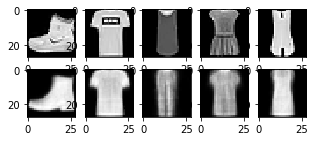

EPOCH : 2


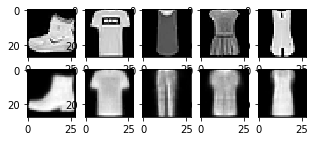

EPOCH : 3


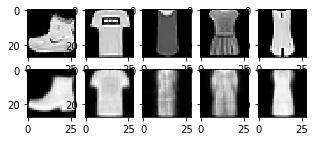

EPOCH : 4


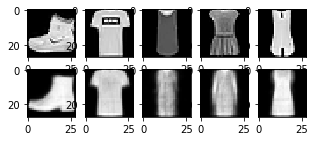

EPOCH : 5


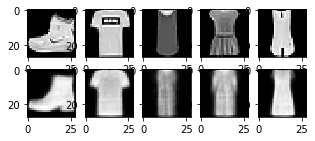

EPOCH : 6


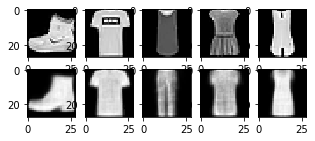

EPOCH : 7


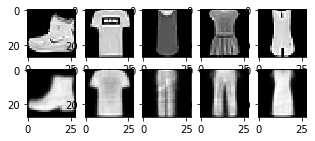

EPOCH : 8


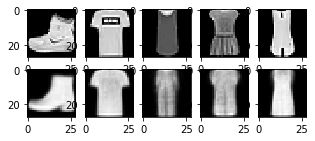

EPOCH : 9


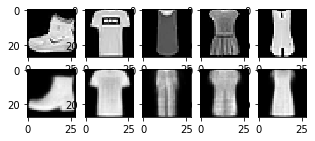

EPOCH : 10


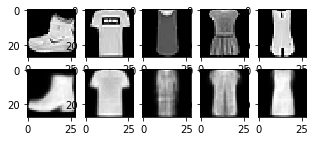

In [14]:
#학습 실행과 시각화 

for epoch in range(1,EPOCH+1):
    train(autoencoder, train_loader)
    
    #디코더한 이미지 시각화 ( 2열)
    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)
    
    #원본과 디코딩 결과 비교 (2행 5열, 이폭수 출력)
    f, a = plt.subplots(2,5, figsize=(5,2))
    print('EPOCH :', epoch)
    
    #맷플롯립은 텐서 지원안하므로 넘파이 행렬로 변환(1god)
    for i in range(5):
        img = np.reshape(view_data.data.numpy()[i],(28,28))
        a[0][i].imshow(img, cmap = 'gray')
    #2행, gpu를 이용하면 모델 출력값이 남아있어 일반메모리로 가져온 후 넘파이 행렬로 변환, CPU의 경우 위의 코드이용해도 무방    
    for i in range(5):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28, 28))
        a[1][i].imshow(img, cmap='gray')
    plt.show()
